# MMLDT-CSET 2021

# Short course #:

# **Geometric learning for hyperelastic energy function**

Instructors: Prof. Waiching Sun, Mian Xiao (Columbia University)

Programmer: Mian Xiao

How to cite: Vlassis, N. N., Ma, R., & Sun, W. (2020). Geometric deep learning for computational mechanics part i: Anisotropic hyperelasticity. Computer Methods in Applied Mechanics and Engineering, 371, 113299.[URL](https://www.sciencedirect.com/science/article/pii/S0045782520304849)

## Outline

1. Install the torch-geometric package
2. Prepare data
3. Data scaling
4. Define data loader
5. Run hybrid Sobolev training with graph nerual networks (GNN)
6. Test results


## Preliminaries

A general constitutive law in the finite deformation range can be stated as follows:
$$ \psi = \psi(C) $$ where $\psi$ is the stored energy function, $C$ is the right Cauchy-Green stretch tensor. We can recover the second Piola-Kirchhoff $S$ stress from this material law by:
$$ S = 2 \frac{\partial \psi}{\partial C} $$

Our goal is to craft a family of constitutive relationship for polycrystal RVEs with similar structures. To this end, we convert the topological information of one RVE into a graph $\mathcal{G}$ and generalize our constitutive model as:
$$ \psi = \psi(C, \mathcal{G}) $$

In other words, we first use a weighted graph as a low-dimensional representation of the microstructures, then again use the geometric learning to further reduce the dimensions and create encoded feature vector that represent the graph with even less dimensions. This encoded feature vector is then used as input for the energy functional to train the neural network constitutive law (See Figure below).

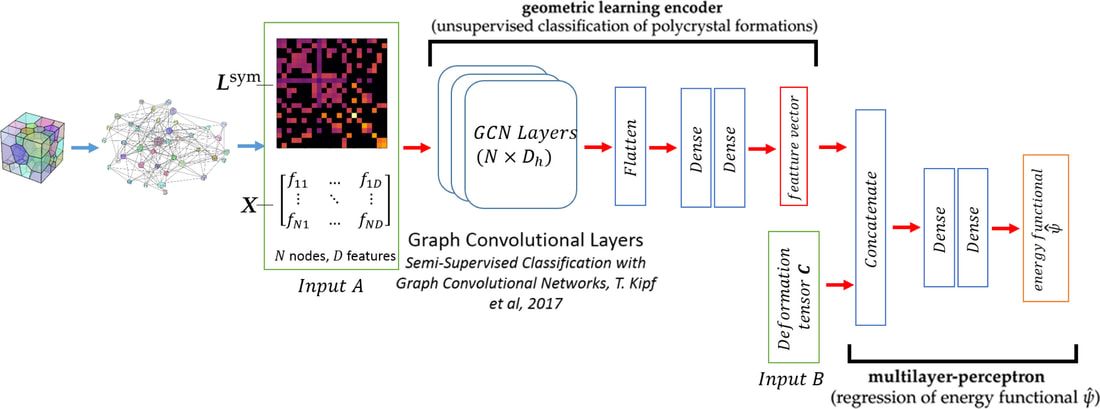

## Install the torch-geometric package compatible with the torch & CUDA versions.

Here, we use the torch-geometric library that include graph convolution neural network that allows one to create encoder for the proposed test. Note tyhat torch-geometric is not the only feasible choice. 

In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
import sys
import os

1.12.1
None


Commands for torch-geometric installation are:  
* pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-TORCH_VERSION+CUDA_VERSION.html
* pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-TORCH_VERSION+CUDA_VERSION.html
* pip install torch-geometric

where CUDA_VERSION and TORCH_VERSION should be replaced by the specific CUDA version (cpu, cu92, cu101, cu102, cu110, cu111) and PyTorch version (1.4.0, 1.5.0, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0), respectively. 

The output of the above cell corresponds to TORCH_VERSION = 1.9.0 and CUDA_VERSION = 10.2 (@09/07/2021). Hence, use the following command:

In [2]:
if 'google.colab' in sys.modules:

    torch_version = torch.__version__

    if torch.version.cuda == None:
        torch_version += "+cpu"

    !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_version}.html
    !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch_version}.html
    !pip install torch-geometric

## Prepare graph database

Here, we would use the a polycrystal structure as an example (see Figure below). An assembles of crystal grains leads to a graph in which individual crystal can be characterize as a node of the graph while the edge indicates connectivity. Material and geometric features of individual particles are then stored as node weights. 
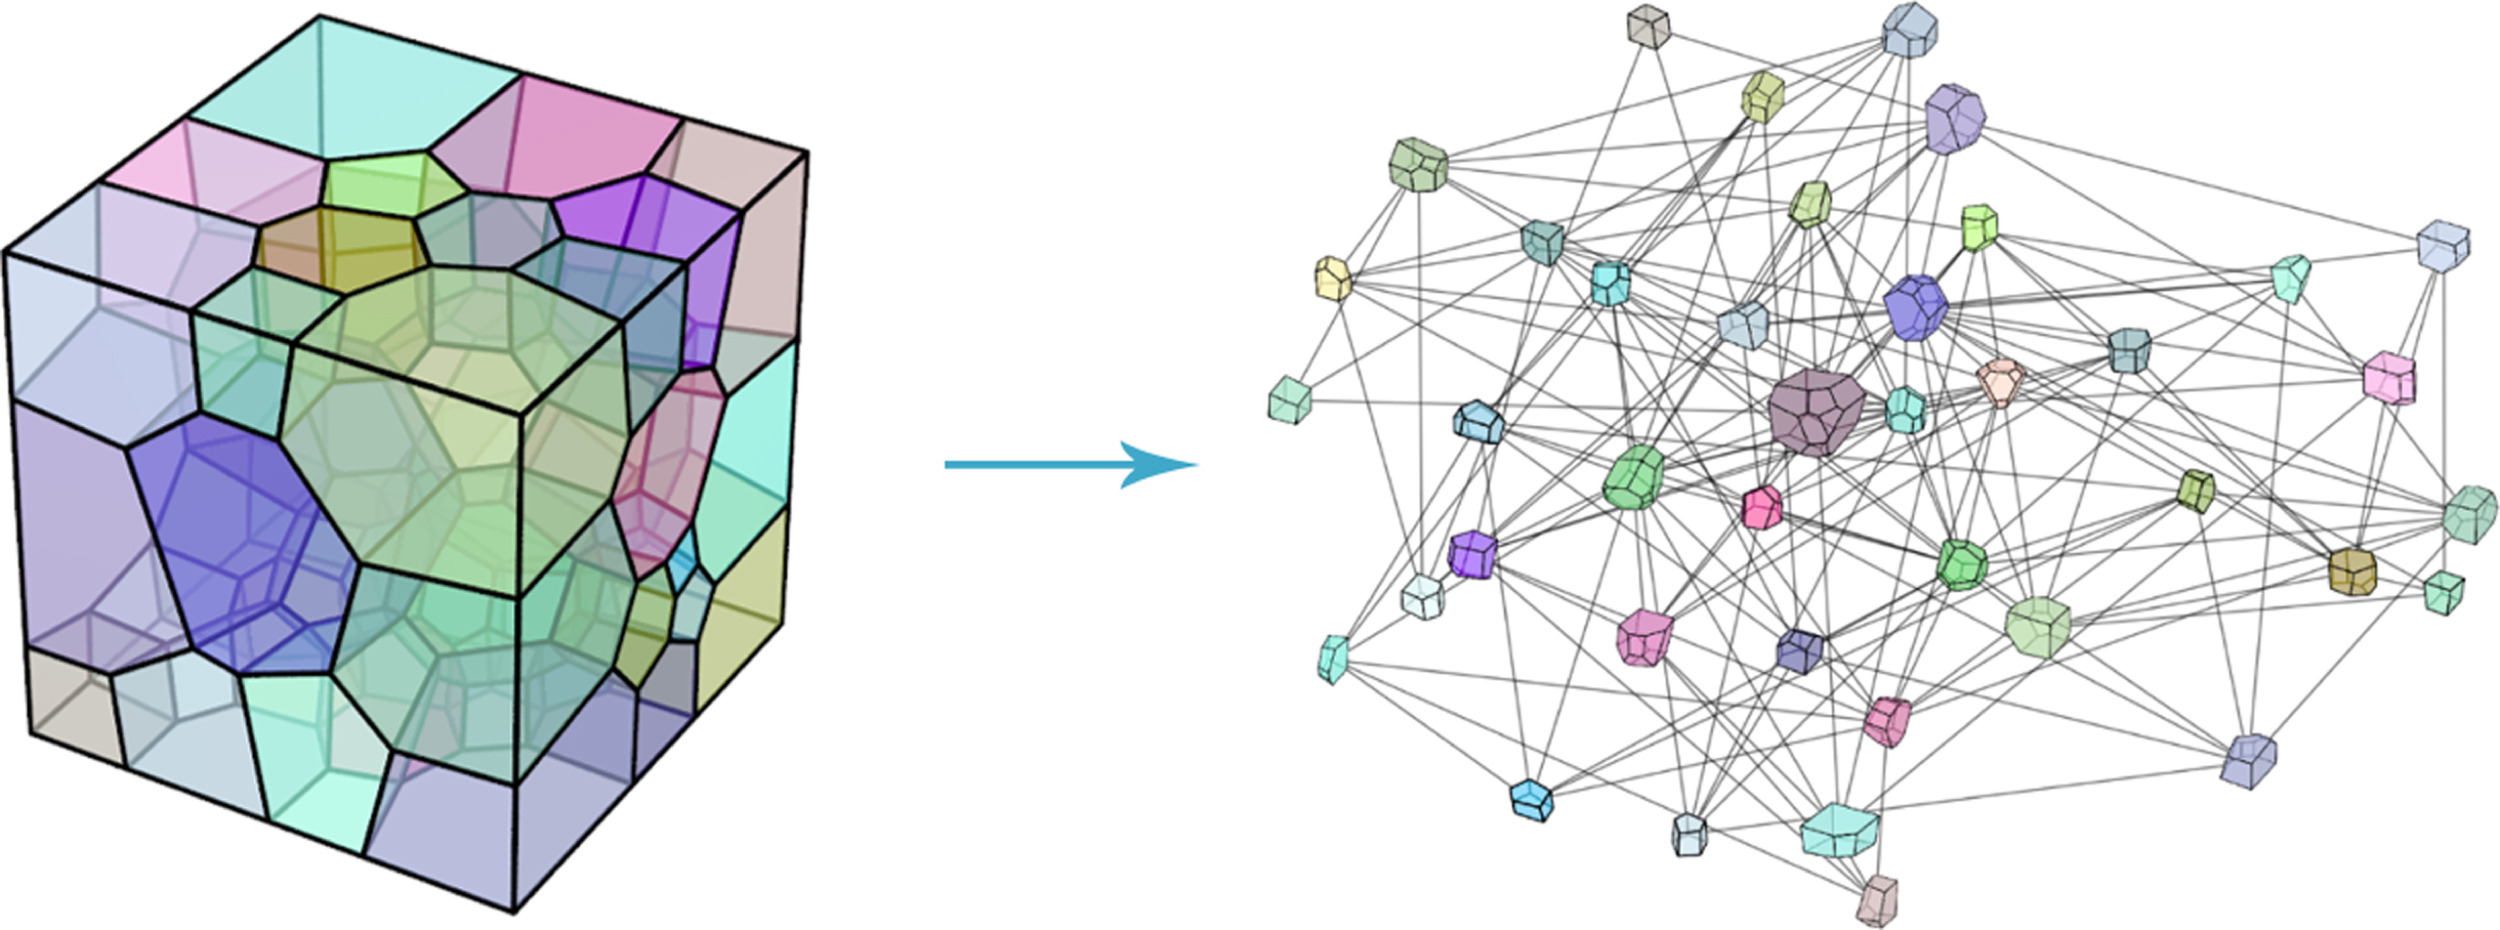

In [3]:
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/HectorLob/MMLDT_Course.git
    %cd MMLDT_Course

In [ ]:
from geom_learn import MixGNN, train_H1_scaled_hybrid

In [ ]:
if 'google.colab' in sys.modules:

    from google.colab import drive
    drive.mount('/gdrive', force_remount=True)

    # change directory from your top level google drive to the RL folder (make sure step 1 is already done!)
    %cd /gdrive/My\ Drive/MMLDT_graduate_short_course/Instructor_Steve_Sun_Jupyter_notebook/Lab3C_Geometric_learning_for_hyperelasticity_pyTorch/

    """
    make sure we have two folders:
        elasticity
        graph_process
    """
    !ls

We have simulation results (3D) for 150 RVE composed of polycrystals under elastic material assumptions. The quantified graph representation data (Vlassis et. al, 2021) are stored in folder *graph_process*, while the simulation results are stored in folder *elasticity*. Organization of the graph data in the *graph_process* folder:

* graph_process
  * database
    * tesselations
      * RVE_1
      * RVE_2
      * ......
      * RVE_150

Each RVE is generated by a *Neper*, which is a software package for polycrystal generation and meshing. In each RVE_x folder, we have several geometrical features (as graph nodal features) for all crystals in the corresponding RVE, and the graph adjacency matrix. We use these to create a graph $\mathcal{G}$ with nodal features $X$ and Adjacency matrix $A$ for each RVE.


**Please wait, the next cell runs for around 5 minutes.**

In [1]:
import numpy as np
import copy

import torch_geometric as torchG
from torch.autograd import Variable, grad
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.autograd.functional import jacobian, hessian

torch.set_default_dtype(torch.float64)

In [4]:
# name of polycrystal features
items = ['vol','neighnb','area','diameq','sphericity','dihangleav','facenb','euler_1','euler_2','euler_3']
n_features = len(items)
# placeholders for graph data
gnn_data_list = []
gnn_feature_list = []

if 'google.colab' in sys.modules:
    first_rve_path = ('/gdrive/MyDrive/MMLDT_graduate_short_course/'
                      'Instructor_Steve_Sun_Jupyter_notebook/'
                      'Lab3C_Geometric_learning_for_hyperelasticity_pyTorch/'
                      'graph_process/database/tesselations/RVE_1')

else:
    first_rve_path = ('/home/hector/Github/MMLDT_course/'
                      'MMLDT_graduate_short_course/'
                      'Instructor_Steve_Sun_Jupyter_notebook/'
                      'Lab3C_Geometric_learning_for_hyperelasticity_pyTorch/'
                      'graph_process/database/tesselations/RVE_1')

os.chdir(first_rve_path)

for k in range(1,151):
    working_dir = '../RVE_'+str(k)+'/'
    os.chdir(working_dir)
    
    # load graph connectivity from the stored adjacency matrix
    A = np.load('A.npy').astype(np.int32)
    n_nodes = A.shape[0]
    n_edges = A.sum() // 2
    edge_index = np.zeros((2,n_edges), dtype=np.int32)
    # write to edge_list
    cnt = 0
    for i in range(n_nodes):
        for j in range(i, n_nodes):
            if A[i,j] > 0:
                edge_index[0,cnt] = i
                edge_index[1,cnt] = j
                cnt += 1
    
    # load crystal data from txt file
    X = np.zeros((n_nodes,n_features), dtype=np.float64)
    for i in range(n_features):
        X[:,i] = np.loadtxt('poly/' + items[i] + '.txt')
    
    gnn_feature_list.append( torch.tensor(X) )
    gnn_data_list.append( torchG.data.Data(torch.tensor(X), torch.tensor(edge_index,dtype=torch.long), torch.tensor([k-1])) )

    if k % 10 == 0:
        print('RVE '+str(k)+' done.')

## Prepare the database from FFT simulation for the energy function

For each RVE, we have the following historical responses:

* $F-I$: incremental deformation gradient 
* $P$: first Piola-Kirchhoff stress
* $\psi$: stored energy

The right Cauchy-Green stretch tensor is computed as:
$$ C = F^TF $$

The second Piola-Kirchhoff stress is computed as:
$$ S = F^{-1}P $$



For the supervised learning branch, we need to create "labels" for the training. These "labels" are already obtained from FFT simulations prior to the training and available in the database. The important issue here is how the microstrucrtures are represented. Since we would like to generate sufficient data such that when a new microstructure is provided, a corresponding energy functional can be derived, the data demand is much higher than the supervised learning to generate surrogate for one RVE. 

**Please wait, the next cell runs for around 1 minutes.**

In [ ]:
"""
    for large deformation cases
    convert F, P to C, S
"""
def convert_Defgrad_and_PKStress( dF_ , P_ ):
    # F = dF + I
    n_samples = dF_.shape[0]
    F_ = dF_.reshape(n_samples, 3,3)
    P_ = P_.reshape(n_samples, 3,3)
    C_ = np.zeros_like(F_)
    S_ = np.zeros_like(C_)
    for i in range(n_samples):
        F_[i,:,:] += np.eye(3)
        Fi = F_[i,:,:]
        C_[i,:,:] = Fi.transpose() @ Fi
        S_[i,:,:] = np.linalg.inv(Fi) @ P_[i,:,:]
    C_ = C_.reshape(n_samples, 9)
    S_ = S_.reshape(n_samples, 9)
    return C_, S_

# placeholders for energy data
energy_data_list = []
stretch_data_list = []
PKStress_data_list = []

for k in range(1,151):
    working_dir = '../RVE_'+str(k)+'/'
    os.chdir(working_dir)
    
    psi = np.load('psi.npy')
    # the input from 'deformation_gradient.npy' is actually F - I
    dF_ = np.load('deformation_gradient.npy')
    P_ = np.load('PKstress.npy')
    
    # compute C = F^T * F and S = F^-1 * P
    C_, S_ = convert_Defgrad_and_PKStress( dF_ , P_ )
    # because S = 2* d\psi / dC
    # we should use 0.5*S as the supervision on gradients
    S_ /= 2.
    energy_data_list.append(psi)
    stretch_data_list.append(C_)
    PKStress_data_list.append(S_)

In [ ]:
if 'google.colab' in sys.modules:
    #cd '/content'
    os.chdir('/content')

else:
    os.chdir('/home/hector/Github/MMLDT_course')

## Scale the data to 0 mean and unit standard deviation

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scalers for normalization
gnn_data_scaler = StandardScaler()
energy_data_scaler   = StandardScaler()
stretch_data_scaler  = StandardScaler()
PKStress_data_scaler = StandardScaler()
PKStress_scaler_alt = MinMaxScaler()
gnn_data_scaler.fit(torch.cat(gnn_feature_list,dim=0).numpy().reshape(-1,n_features))
energy_data_scaler.fit  (np.concatenate(energy_data_list  , axis=0).reshape(-1,1))
stretch_data_scaler.fit (np.concatenate(stretch_data_list , axis=0).reshape(-1,9))
PKStress_data_scaler.fit(np.concatenate(PKStress_data_list, axis=0).reshape(-1,9))
# alternative min max scaler to check the validation acc
PKStress_scaler_alt.fit(np.concatenate(PKStress_data_list, axis=0).reshape(-1,9))

for k in range(150):
    # normalize GNN nodal features and energy model data
    tmp_gnn_features = gnn_data_scaler.transform(gnn_data_list[k].x)
    gnn_data_list[k].x = torch.tensor(tmp_gnn_features)
    energy_data_list[k]   = energy_data_scaler  .transform(energy_data_list[k])
    energy_data_list[k]   = torch.tensor(energy_data_list[k])
    stretch_data_list[k]  = stretch_data_scaler .transform(stretch_data_list[k])
    stretch_data_list[k]  = torch.tensor(stretch_data_list[k])
    PKStress_data_list[k] = PKStress_data_scaler.transform(PKStress_data_list[k])
    PKStress_data_list[k] = torch.tensor(PKStress_data_list[k])

## Construct the dataloader

In [ ]:
# collect train_X, train_Y for each gnn batch
energy_scale  = 1. / energy_data_scaler.scale_
strain_scales = stretch_data_scaler.scale_
stress_scales = PKStress_data_scaler.scale_
stress_limits = PKStress_data_scaler.mean_
data_scales = (strain_scales, energy_scale, stress_scales, stress_limits)
trainX_list = []
trainY_list = []
for bch in range(10):
    masks = [torch.full( (stretch_data_list[15*bch+m]. shape[0], 1), m, dtype=torch.int32 ) for m in range(15)]
    train_X = torch.stack(stretch_data_list[15*bch : 15*(bch+1)]).reshape((-1,9))
    train_X = torch.cat( (train_X, torch.stack(masks).reshape(-1,1)), axis=1 )
    trainX_list.append(Variable(train_X))
    train_Y = torch.cat( (torch.stack(energy_data_list[15*bch : 15*(bch+1)]).reshape(-1,1),\
        torch.stack(PKStress_data_list[15*bch : 15*(bch+1)]).reshape(-1,9) ), axis=1)
    trainY_list.append(Variable(train_Y))

# config parameters
BATCH_SIZE = 64
EPOCH = 160
MODEL_PATH = 'gnn_elas.pt'

# construct the dataloaders
train_loaders = []
valid_loaders = []
valid_split = .2
gnn_loaders = []
for bch in range(10):
    gnn_loaders.append( torchG.data.DataLoader(gnn_data_list[15*bch : 15*(bch+1)], batch_size=15) )
    dataset_len = trainX_list[bch].shape[0]
    indices = list(range(dataset_len))
    # Randomly splitting indices:
    valid_idx = np.random.choice(indices, size=int(np.floor(valid_split * dataset_len)), replace=False)
    train_idx = list(set(indices) - set(valid_idx))
    # Defining the samplers for each phase based on the random indices:
    train_sampler = Data.SubsetRandomSampler(train_idx)
    valid_sampler = Data.SubsetRandomSampler(valid_idx)

    torch_dataset = Data.TensorDataset(trainX_list[bch], trainY_list[bch])
    train_loader = Data.DataLoader(torch_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    valid_loader = Data.DataLoader(torch_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
    train_loaders.append(train_loader)
    valid_loaders.append(valid_loader)

## Launch a hybrid H1 training

**Please wait, the next cell runs for at least 35 minutes.**

In [ ]:
net = MixGNN(inp=9, out=1, hidden=256, gnn_inp=n_features, gnn_out=9, gnn_hidden=64)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.7)

state_energy, lossTotal, lossVal, lossGrad, vlossTotal, vlossVal, vlossGrad =\
    train_H1_scaled_hybrid(net, train_loaders, valid_loaders, gnn_loaders, EPOCH, BATCH_SIZE, optimizer, scheduler, data_scales, lam1=.5)
# reserve the last 15 RVEs for test purpose

torch.save(state_energy, MODEL_PATH)

## Test the loss on a certain data chunk

In [ ]:
# test graph data from gnn_loader[0]
num_gnn_batch = 0
for _, temp_data in enumerate(gnn_loaders[1]):
    num_gnn_batch += 1
assert(num_gnn_batch == 1)
gnn_data = copy.deepcopy(temp_data)


# prepare test X
test_X = Variable(trainX_list[1][:,:-1], requires_grad = True)
test_masks = trainX_list[1][:,-1].long()

test_true_strain = stretch_data_scaler.inverse_transform( test_X.detach().numpy() )
test_true_energy = energy_data_scaler.inverse_transform( trainY_list[1][:,0:1].detach().numpy() )
test_true_stress = PKStress_data_scaler.inverse_transform( trainY_list[1][:,1:].detach().numpy() )

# test routine
net.load_state_dict(state_energy)
net.eval()
test_Y = net(test_X, test_masks, gnn_data.x, gnn_data.edge_index, gnn_data.batch)
test_YGrad, = grad(test_Y.sum(), test_X, create_graph=True)
test_YGrad /= (torch.tensor(strain_scales) * energy_scale)
test_pred_stress = test_YGrad.detach().numpy()

from sklearn.metrics import mean_squared_error
test_loss = mean_squared_error( PKStress_data_scaler.transform(test_pred_stress),\
    PKStress_data_scaler.transform(test_true_stress) )
print('test MSE: ', test_loss)

## Plot stress predictions

In [ ]:
test_plot_range = range(0,10)
strain_hist = test_true_strain[test_plot_range,:]
stress_hist_true = test_true_stress[test_plot_range,:]
stress_hist_pred = test_pred_stress[test_plot_range,:]

fig, axs = plt.subplots(1, 3, figsize=(18,4.5),\
        gridspec_kw={'wspace': 0.4, 'hspace': 0.2})
ax = axs[0]
ax.plot(strain_hist[:,0], stress_hist_true[:,0], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], stress_hist_pred[:,0], 'b--', label='prediction')
ax.set_xlabel("F11", fontsize=15)
ax.set_ylabel("S11", fontsize=15)
ax.set_ylim([0,0.2])
ax.legend(fontsize=12)

ax = axs[1]
ax.plot(strain_hist[:,0], stress_hist_true[:,4], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], stress_hist_pred[:,4], 'b--', label='prediction')
ax.set_xlabel("F11", fontsize=15)
ax.set_ylabel("S22", fontsize=15)
ax.set_ylim([0,0.2])
ax.legend(fontsize=12)

ax = axs[2]
ax.plot(strain_hist[:,0], stress_hist_true[:,1], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], stress_hist_pred[:,1], 'b--', label='prediction')
ax.set_xlabel("F11", fontsize=15)
ax.set_ylabel("S12", fontsize=15)
ax.set_ylim([0,0.2])
ax.legend(fontsize=12)